In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn import metrics

# Questão 1 : Finetuning com o modelo VGG11

# Dataset 1

### Treinamento a partir de uma base propria de imagens - Intel Image Classification
<p>
Context: This is image data of Natural Scenes around the world.
</p>

<p>
<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*Y1y83HN7oI98EJT3LQgv-g.png" alt="Drawing"  width="500"/>

Content: This Data contains around 25k images of size 150x150 distributed under 6 categories.
  <ul>
    <li>buildings</li>
    <li>forest</li>
    <li>glacier</li>
    <li>mountain</li>
    <li>sea</li>
    <li>street</li>
  </ul>
</p>

<p>
Fonte: <a href="https://www.kaggle.com/datasets/puneet6060/intel-image-classification">Intel Image Classification</a>
</p>





### Usar Gdown para realizar a descarga de um arquivo desde o drive

In [2]:
# instalação da biblioteca gdown
!pip install gdown

In [3]:
# importando a biblioteca
import gdown


<img src="https://drive.google.com/uc?id=1VgEEHaw-5798fIY03iWIYOIYK4-kkiNW" alt="Drawing"  width="900"/>

```
gdown --id <put-the-ID>
```

In [4]:
# Realizando a descarga do Intel Dataset usando o id do gdrive do arquivo
!gdown --id 16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft
From (redirected): https://drive.google.com/uc?id=16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft&confirm=t&uuid=c205950a-4f1d-4b65-abef-8fba80e109d2
To: /content/dataset.zip
100% 253M/253M [00:12<00:00, 20.0MB/s]


In [5]:
# biblioteca para descomprimir o arquivo zip
import zipfile
import os

In [6]:
# funçao que realiza a descompressão do arquivo
def unzip_dataset(filename, directory):
  """
  filename: nome do arquivo, incluir o endereço onde está localizado o arquivo
  directory: pasta onde será decomprimido o arquivo
  """
  zip_ref = zipfile.ZipFile(filename, 'r')
  zip_ref.extractall(directory)
  zip_ref.close()

### Descomprimir arquivo zip

In [7]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/content/data/Intel/'
unzip_dataset(filename='/content/dataset.zip', directory=data_dir )

In [8]:
%ls /content/data/Intel/test

buildings/  forest/  glacier/  mountain/  sea/  street/


### Transformações geométricas nas imagens

In [9]:
input_size = 224
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


### Inicializando Image dataset (ImageFolder)

In [15]:
print("Incializando Datasets ...")

# Criar conjuntos de dados de treinamento e validação
# Inserir código
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# Criar um dicionario com os dataset para treino e test
#inserir codigo

Incializando Datasets ...


### Particionar o conjunto de treino em treino e validacão

In [16]:
# conjunto de treino é divido em treino (80%) e validação (20%)
train_dataset_split, val_dataset_split = torch.utils.data.random_split(image_datasets['train'], [0.8, 0.2])

# é adicionado no dicionario image_datasets o conjunto de validação e o conjunto de treino é atualizado
image_datasets['val'] = val_dataset_split
image_datasets['train'] = train_dataset_split

### Carregando Dataloader

In [19]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Criar dataloaders de treinamento e validação
# utilizar um dicionario para o dataloader dos conjunto de train, val e test
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
#inserir código

# Detectar a disponibilidade de uma GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")

### Função que congela ou descongela as camadas de uma rede

<p> Por *default* são carregadas descongeladas, ou seja, permite que todos os pesos da rede sejam atualizados durante o treino.</p>

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    '''
    model: modelo que será utilizado (a rede neural)
    feature_extracting: se True, todas as camada serão congeladas, se False, todas serão descongeladas
    '''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Funções de treino e predição

In [21]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    '''
    model: modelo (a rede neural)
    criterion: função de perda (loss)
    optimizer: otimizador
    train_loader: dataloader do conjunto de treino
    test_loader: dataloader do conjunto de teste
    epochs: número de épocas
    '''
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        # Treino
        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        #
        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

In [22]:
def predict_module(model, test_loader):
    '''
    model: modelo (a rede neural)
    test_loader: dataloader do conjunto de teste
    '''
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

### Função que grafica as funções de perda(custo) do treino e da validação

In [23]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

## Matriz de Confusão

In [24]:
def matriz_confusao(true_labels, predicted, display_labels=[0,1,2]):
    matriz = metrics.confusion_matrix(true_labels, predicted)
    tot = np.sum(matriz, axis=1, keepdims=True)
    np.set_printoptions(precision=2)
    m_porc = matriz/tot
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=display_labels)
    disp.plot(values_format='.2f')
    plt.show()

### Definição das redes MLP e para Finetuning

In [25]:
def make_layers(cfg, in_channels = 3):
    layers = []
    for v in cfg:
        layers += [nn.Linear(in_channels, v), nn.ReLU()]
        in_channels = v
    return nn.Sequential(*layers)

In [26]:
class MeuMLP(nn.Module):
    def __init__(self,entrada=4,camadas_escondidas=256 ,saida=3):
        super(MeuMLP, self).__init__()
        self.hidden_layers_num = camadas_escondidas
        self.dense_hidden = make_layers(self.hidden_layers_num, entrada)
        self.fc = nn.Linear(self.hidden_layers_num[-1], saida)

    def forward(self, x):
        x = self.dense_hidden(x)
        x = self.fc(x)
        return x

In [27]:
class FineTuningNetwork(nn.Module):
    def __init__(self, backbone, classifier):
        super(FineTuningNetwork, self).__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x):
        # Passa os dados pelo backbone (CNN pré-treinada)
        features = self.backbone(x)

        # Passa as características extraídas pelo classificador (MLP)
        out = self.classifier(features)
        return out

### Finetuning com rede VGG11

### Rede VGG11
<img src="https://www.researchgate.net/publication/333461196/figure/fig1/AS:764075780894720@1559181270123/VGG-11-structure-diagram.png" alt="Drawing"  width="900"/>



In [28]:
# Carregar o modelo pré-treinado VGG11
backbone = models.vgg11(weights='VGG11_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 69.7MB/s]


### Mostrar as camadas da rede VGG11

In [29]:
print(backbone)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [30]:
# Remover a última camada totalmente conectada (classifier)
backbone = nn.Sequential(*list(backbone.children())[:-1])

# Adicionar uma camada de flatten (conversão para vetor)
backbone.add_module("flatten", nn.Flatten())

# Criar as camadas para classificação
classificador = MeuMLP(entrada=25088, camadas_escondidas=[256, 128, 64, 32] , saida=6 )

In [31]:
print(backbone)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [32]:
# loss and optimizer
model = FineTuningNetwork(backbone=backbone, classifier=classificador)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Congelar as camadas do backbone para não treinar novamente
set_parameter_requires_grad(backbone, feature_extracting=True)

Epoch 1/10 Train Loss: 0.4989 Test Loss: 0.40841915689812086 Duracao: 0:01:16.312443
Epoch 2/10 Train Loss: 0.3898 Test Loss: 0.3731376122195072 Duracao: 0:01:09.053002
Epoch 3/10 Train Loss: 0.3524 Test Loss: 0.4016342739696665 Duracao: 0:01:06.598814
Epoch 4/10 Train Loss: 0.3470 Test Loss: 0.38824493241658237 Duracao: 0:01:08.067649
Epoch 5/10 Train Loss: 0.3159 Test Loss: 0.3709741861591291 Duracao: 0:01:07.921356
Epoch 6/10 Train Loss: 0.3148 Test Loss: 0.3757615425939701 Duracao: 0:01:07.175978
Epoch 7/10 Train Loss: 0.3007 Test Loss: 0.3456774980607217 Duracao: 0:01:07.611197
Epoch 8/10 Train Loss: 0.2939 Test Loss: 0.33668147979511154 Duracao: 0:01:07.234399
Epoch 9/10 Train Loss: 0.2764 Test Loss: 0.350367788689747 Duracao: 0:01:07.732563
Epoch 10/10 Train Loss: 0.2844 Test Loss: 0.3512022877768733 Duracao: 0:01:07.458524


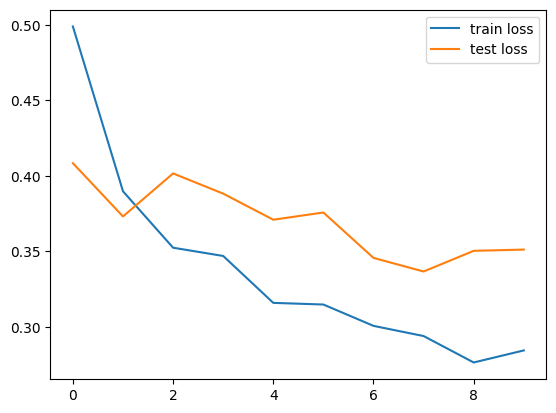

In [33]:
# verificar disponibilidade de placa de vídeo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# treinar
train_losses, test_losses = fit(model, criterion, optimizer, dataloaders_dict['train'], dataloaders_dict['val'], epochs = 10)
plot_losses(train_losses, test_losses)

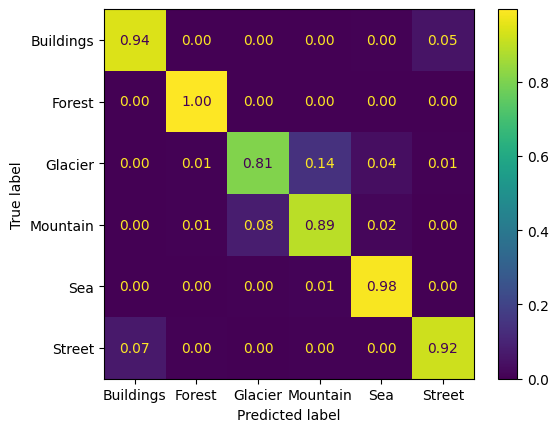

In [34]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model, dataloaders_dict['test'])
matriz_confusao(true_labels, predicted, ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'])

# Questão 2 : Finetuning com o modelo Resnet18

### Resnet18

<img src="https://drive.google.com/uc?id=1dLyh_MBQKigMm_z-i_3js4mElD0nm6uZ" alt="Drawing"  width="900"/>



In [35]:
import os
import pandas as pd
from torchvision.io import read_image
from skimage import io
from PIL import Image

## Base de dados 2: Cats and Dogs

In [36]:
# Realizando a descarga do Intel Dataset usando o id do gdrive do arquivo
!gdown 1sbmin2e6SAfebV_iOjRWffwO-hrgrCem

Downloading...
From (original): https://drive.google.com/uc?id=1sbmin2e6SAfebV_iOjRWffwO-hrgrCem
From (redirected): https://drive.google.com/uc?id=1sbmin2e6SAfebV_iOjRWffwO-hrgrCem&confirm=t&uuid=3227c83e-8425-4867-a696-991473873d1a
To: /content/cat_dogs.zip
100% 68.4M/68.4M [00:02<00:00, 33.3MB/s]


In [37]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/content/data/'
unzip_dataset(filename='/content/cat_dogs.zip', directory=data_dir )

In [38]:
%ls /content/data/cat_dogs

test/  train/  train_cats_dogs.csv  val_cats_dogs.csv


In [40]:
class CSVDataset2D(Dataset):
    def __init__(self, root, img_folder, csv_file, transform = None):
        self.data = pd.read_csv(os.path.join(root, csv_file))
        self.root = root
        self.transform = transform
        self.img_folder = img_folder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].to_numpy()
        # construir o endereço e nome da imagem que deve ser carregada, o nome
        # da imagem está em row[0] e o endereço da base em root e o pasta em img_folder
        # img_path = root + img_folder + nome_imagem
        img_path = os.path.join(self.root, self.img_folder, row[0])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(0 if row[1] == 'cat' else 1, dtype=torch.long)

        return image, label

In [48]:
input_size = 224
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Incializando Datasets e Dataloaders...")

# Criar conjuntos de dados de treinamento e validação
annotation_path = '/content/data/cat_dogs'
image_datasets2 = {}
image_datasets2['train'] = CSVDataset2D(annotation_path, 'train', 'train_cats_dogs.csv', data_transforms['train'])
image_datasets2['test'] = CSVDataset2D(annotation_path, 'test', 'val_cats_dogs.csv', data_transforms['test'])

Incializando Datasets e Dataloaders...


In [49]:
# conjunto de treino é divido em treino (80%) e validação (20%)
train_dataset_split2, val_dataset_split2 = torch.utils.data.random_split(image_datasets2['train'], [0.8, 0.2])
# é adicionado no dicionario image_datasets o conjunto de validação e o conjunto de treino é atualizado
image_datasets2['val'] = val_dataset_split2
image_datasets2['train'] = train_dataset_split2

In [50]:
# Criar dataloaders de treinamento e validação
# utilizar um dicionario para o dataloader dos conjunto de train, val e test
batch_size = 32
dataloaders_dict2 = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size=batch_size, shuffle=True, num_workers=4)
                    for x in ['train', 'val', 'test']}

# Detectar a disponibilidade de uma GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


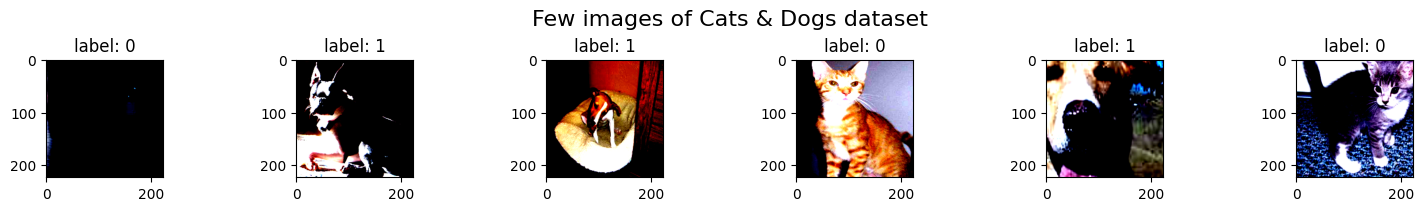

In [51]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of Cats & Dogs dataset", fontsize=16)
for x, y in dataloaders_dict2['train']:
  for i in range(nb_digits_to_display):
    ax[i].imshow(np.transpose(x[i].numpy(), (1,2,0)), cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

In [52]:
# carregar o modelo Resnet18
backbone2 = models.resnet18(weights='ResNet18_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [53]:
print(backbone2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
# Remover a última camada totalmente conectada (classifier)
backbone2 = nn.Sequential(*list(backbone2.children())[:-1])

# Adicionar uma camada de flatten (conversão para vetor)
backbone2.add_module("flatten", nn.Flatten())

# Criar as camadas para classificação
classificador2 = MeuMLP(entrada=512, camadas_escondidas=[64, 32] , saida=2 )

In [55]:
# loss and optimizer
model2 = FineTuningNetwork(backbone=backbone2, classifier=classificador2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

# Congelar as camadas do backbone para não treinar novamente
set_parameter_requires_grad(backbone2, feature_extracting=True)

In [56]:
print(model2)

FineTuningNetwork(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

Epoch 1/10 Train Loss: 0.3234 Test Loss: 0.2369331534092243 Duracao: 0:00:07.825625
Epoch 2/10 Train Loss: 0.1816 Test Loss: 0.1542727077523103 Duracao: 0:00:11.118598
Epoch 3/10 Train Loss: 0.1800 Test Loss: 0.15688753987734133 Duracao: 0:00:09.307478
Epoch 4/10 Train Loss: 0.1696 Test Loss: 0.15557836511960396 Duracao: 0:00:07.868748
Epoch 5/10 Train Loss: 0.1568 Test Loss: 0.17429323093249247 Duracao: 0:00:10.263006
Epoch 6/10 Train Loss: 0.1943 Test Loss: 0.1486759025316972 Duracao: 0:00:07.784919
Epoch 7/10 Train Loss: 0.1564 Test Loss: 0.12757073829953486 Duracao: 0:00:10.719705
Epoch 8/10 Train Loss: 0.1656 Test Loss: 0.16837098821997643 Duracao: 0:00:08.328386
Epoch 9/10 Train Loss: 0.1871 Test Loss: 0.20212102509461916 Duracao: 0:00:09.716553
Epoch 10/10 Train Loss: 0.1627 Test Loss: 0.11424980885707416 Duracao: 0:00:09.652733


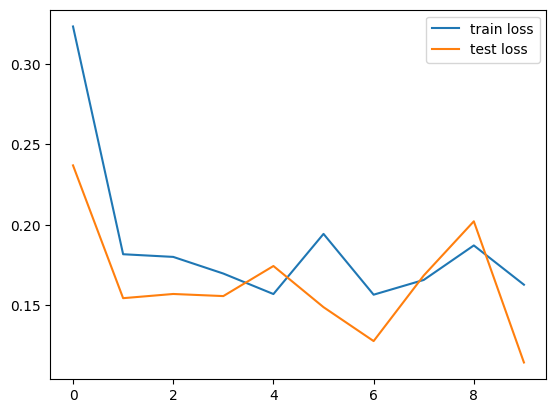

In [57]:
# verificar disponibilidade de placa de vídeo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)
# treinar
train_losses, test_losses = fit(model2, criterion, optimizer, dataloaders_dict2['train'], dataloaders_dict2['val'], epochs = 10)
plot_losses(train_losses, test_losses)

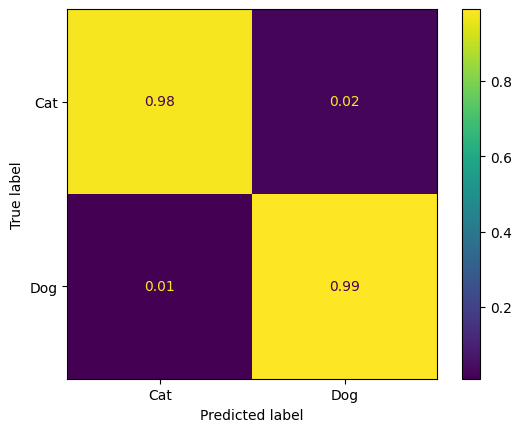

In [58]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model2, dataloaders_dict2['test'])
matriz_confusao(true_labels, predicted, ['Cat', 'Dog'])